![](https://moneylion.nyc3.cdn.digitaloceanspaces.com/wp-content/uploads/2023/01/06170512/Untitled-design-88.webp)

Install Some Missing Libraries

In [102]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [103]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [104]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [105]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [106]:
pip install XGboost

Note: you may need to restart the kernel to use updated packages.


In [107]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import yfinance as yf

import pandas_datareader as pdr
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
######################################################################################
stock_data = yf.download('AAPL') # you can choose whatever stockticker you want

num_days_pred=30 # Number of days you want to predict in the future the higher the less accuracy
######################################################################################

# Here I choose to only use the last 3 years of stock data 
slice = int(len(stock_data)- 356*3)
stock_data = stock_data.iloc[slice:]

# Here I Choose to continue with only Close value column since that is what we care about 
stock_data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)


# Function to calculate mean absolute error percentage
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def add_lags(df,num_days_pred=num_days_pred):
    target = 'Close'
    df['lag1'] = df[target].shift(num_days_pred)  
    df['lag2'] = df[target].shift(num_days_pred*2)    
    df['lag3'] = df[target].shift(num_days_pred*3)    
    df['lag4'] = df[target].shift(num_days_pred*4)    
    df['lag5'] = df[target].shift(num_days_pred*5)
    df['lag6'] = df[target].shift(num_days_pred*6)
    df['lag7'] = df[target].shift(num_days_pred*7)
    df['lag8'] = df[target].shift(num_days_pred*8)
    df['lag9'] = df[target].shift(num_days_pred*9)
    df['lag10'] = df[target].shift(num_days_pred*10)
    df['lag11'] = df[target].shift(num_days_pred*11)
    df['lag12'] = df[target].shift(num_days_pred*12)



    return df

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

[*********************100%%**********************]  1 of 1 completed


# XGBOOST

In [108]:
df_xgb = stock_data.copy()

In [109]:
def xgboostmodel(df_xgb,add_lags,create_features,num_days_pred=num_days_pred):

    df_xgb = create_features(df_xgb)
    df_xgb = add_lags(df_xgb)
    
    X = df_xgb.drop(columns='Close')
    y = df_xgb['Close']
    return X,y
X,y = xgboostmodel(df_xgb ,add_lags,create_features,num_days_pred=30)

In [110]:
# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to search
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'verbosity': 0,
        #'tree_method': 'gpu_hist',
    }
    
    # Initialize XGBoost regressor with the suggested parameters
    xgb = XGBRegressor(**param)
    
    # Fit the model on training data
    xgb.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = xgb.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmse


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best trial and parameters found
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Use the best parameters to train the final model
best_params = best_trial.params
xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = xgb_best.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("Test RMSE:", rmse_test)

[I 2024-04-11 17:49:18,279] A new study created in memory with name: no-name-56f8b468-1148-45a5-a0b3-f046c5298d86
[I 2024-04-11 17:49:18,879] Trial 0 finished with value: 3.542923334915673 and parameters: {'n_estimators': 445, 'max_depth': 5, 'learning_rate': 0.021857132507995848, 'subsample': 0.9758117023651196, 'colsample_bytree': 0.8949201513156595, 'reg_alpha': 3.817488323034859, 'reg_lambda': 2.4654627981009316}. Best is trial 0 with value: 3.542923334915673.
[I 2024-04-11 17:49:19,936] Trial 1 finished with value: 3.4958702080711177 and parameters: {'n_estimators': 649, 'max_depth': 7, 'learning_rate': 0.027827249242728877, 'subsample': 0.9287750172044938, 'colsample_bytree': 0.8341813199348831, 'reg_alpha': 9.115561543845628, 'reg_lambda': 6.207753488909333}. Best is trial 1 with value: 3.4958702080711177.
[I 2024-04-11 17:49:20,234] Trial 2 finished with value: 3.378448553018031 and parameters: {'n_estimators': 360, 'max_depth': 4, 'learning_rate': 0.07695556152124974, 'subsamp

Best trial:
  Value: 3.116941537636143
  Params: 
    n_estimators: 1000
    max_depth: 8
    learning_rate: 0.01911499475534985
    subsample: 0.7202916841393343
    colsample_bytree: 0.663710917185224
    reg_alpha: 1.1766298445686187
    reg_lambda: 1.6056331896376006
Test RMSE: 3.116941537636143


## Evaluate

In [111]:
y_pred_test_xgb = xgb_best.predict(X_test)
xgb_loss = mean_absolute_percentage_error(y_test, y_pred_test_xgb) 
print(f"ERROR PERCENT = { mean_absolute_percentage_error(y_test, y_pred_test_xgb) }% ")

ERROR PERCENT = 1.685062157557371% 


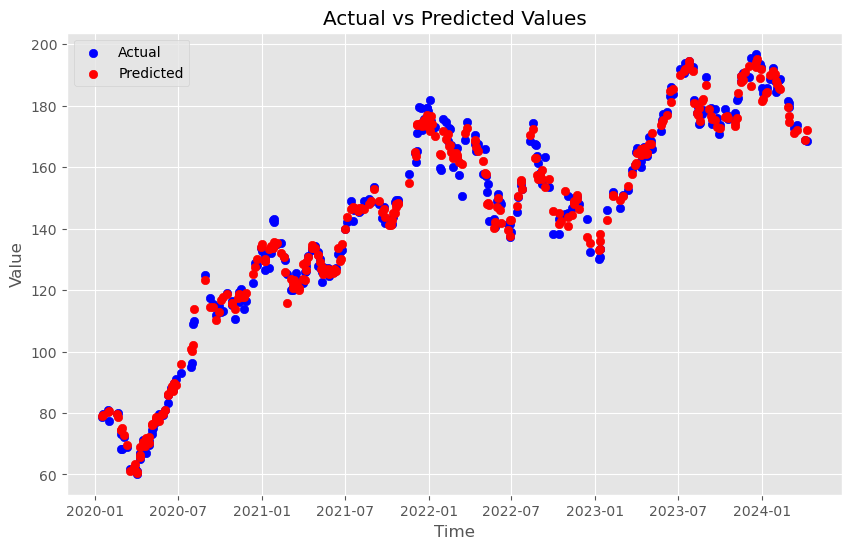

In [112]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='blue', label='Actual')
plt.scatter(X_test.index, y_pred_test_xgb , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

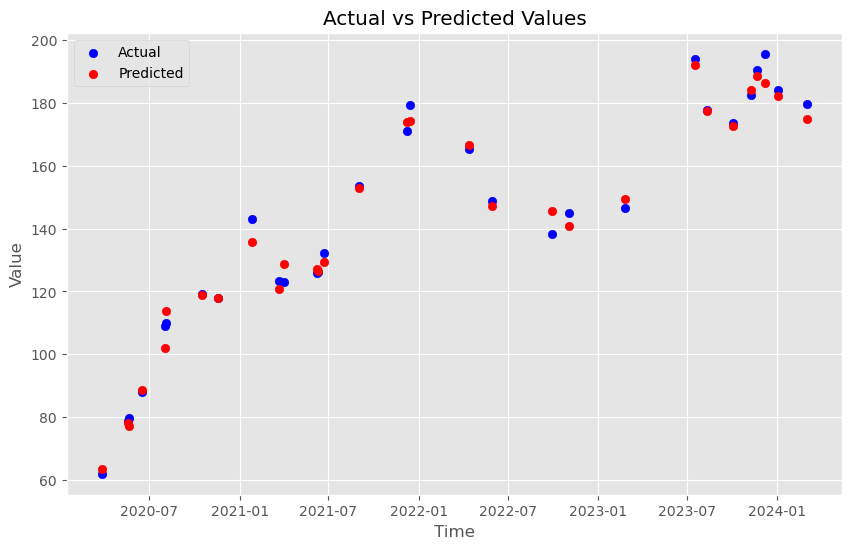

In [113]:
# Let's ZoomIn
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index[:30], y_test[:30], color='blue', label='Actual')
plt.scatter(X_test.index[:30], y_pred_test_xgb[:30] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

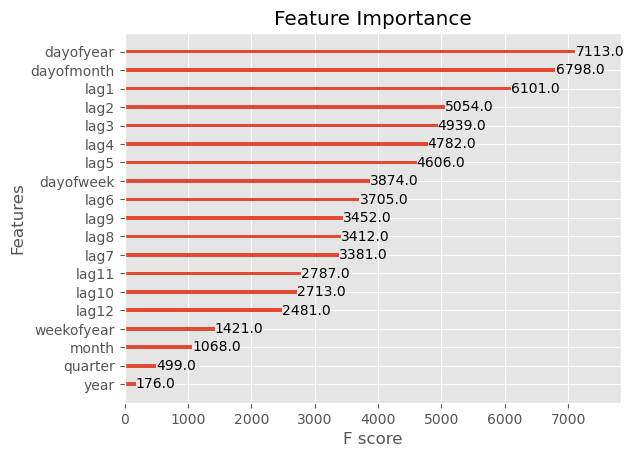

In [114]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_best, max_num_features=20)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()

## Predict In The Future

In [115]:
start = df_xgb.index.max()
end = start + pd.Timedelta(days=num_days_pred)

In [116]:
future = pd.date_range(start=start,end=end,freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture']= True
df_xgb['isFuture']= False
df_and_future = pd.concat([df_xgb,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features = df_and_future.query('isFuture').copy()

In [117]:
future_w_features['pred'] = xgb_best.predict(future_w_features.drop(columns=['Close','isFuture']))

In [118]:
prediction_xgb = pd.DataFrame(future_w_features['pred'])
prediction_xgb

,pred
2024-04-11,172.427078
2024-04-12,171.427505
2024-04-13,169.888077
2024-04-14,169.426926
2024-04-15,168.477356
2024-04-16,169.053177
2024-04-17,168.803421
2024-04-18,171.646744
2024-04-19,171.846619
2024-04-20,171.643631


# Prophet

In [119]:
df_prophet = stock_data.copy()

Split

In [120]:
split_date = df_prophet.index[int(len(df_prophet) * 0.8)]
train = df_prophet.loc[df_prophet.index <= split_date].copy()
test = df_prophet.loc[df_prophet.index > split_date].copy()

Preprocess

In [121]:
# Format data for prophet model using ds and y
train_prophet = train.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})

In [122]:
train_prophet 

,ds,y
0,2020-01-14,78.169998
1,2020-01-15,77.834999
2,2020-01-16,78.809998
3,2020-01-17,79.682503
4,2020-01-21,79.142502
...,...,...
850,2023-05-31,177.250000
851,2023-06-01,180.089996
852,2023-06-02,180.949997
853,2023-06-05,179.580002


Training

In [123]:
prophet = Prophet()
prophet.fit(train_prophet)

17:50:31 - cmdstanpy - INFO - Chain [1] start processing


17:50:31 - cmdstanpy - INFO - Chain [1] done processing


In [124]:
# Format data for prophet model using ds and y
test_prophet = test.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})
test_predict = prophet.predict(test_prophet)

Evaluating

In [125]:
porphet_loss = mean_absolute_percentage_error(test['Close'],test_predict['yhat'] )
print(f"ERROR PERCENT = { mean_absolute_percentage_error(test['Close'],test_predict['yhat'] ) }% ")

ERROR PERCENT = 9.453242423808122% 


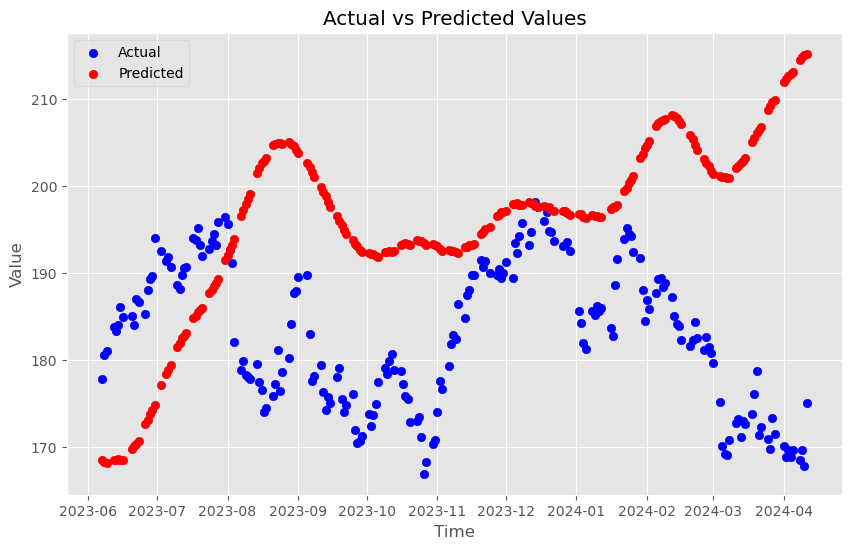

In [126]:
plt.figure(figsize=(10, 6))
plt.scatter(test.index, test['Close'], color='blue', label='Actual')
plt.scatter(test.index, test_predict['yhat'] , color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

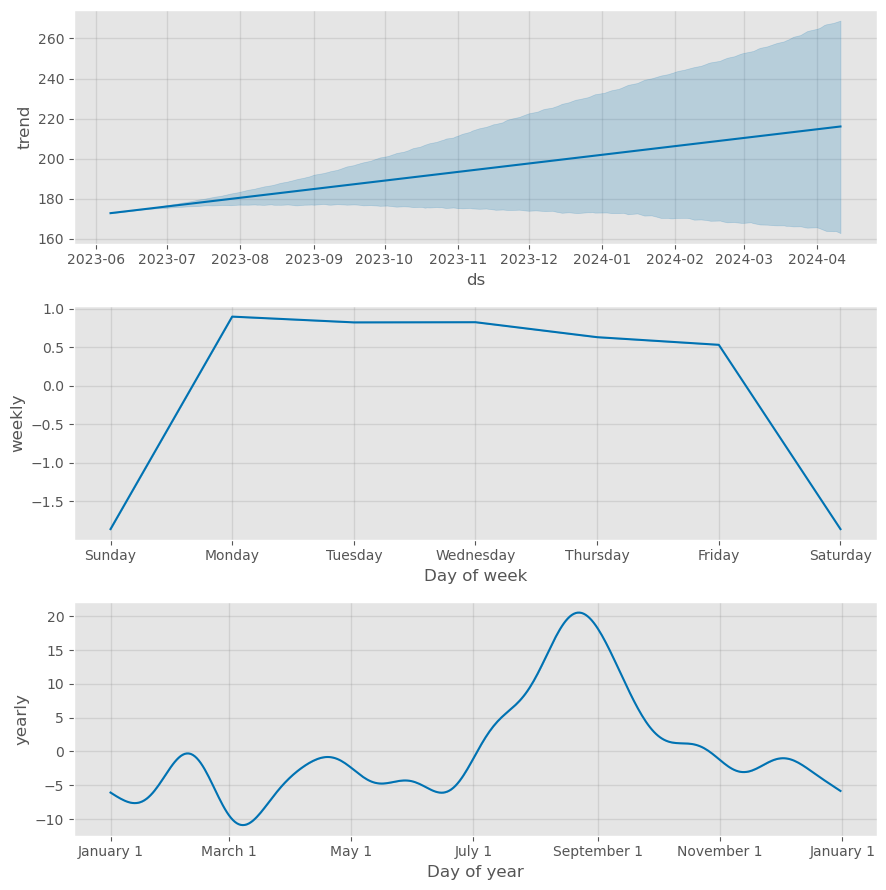

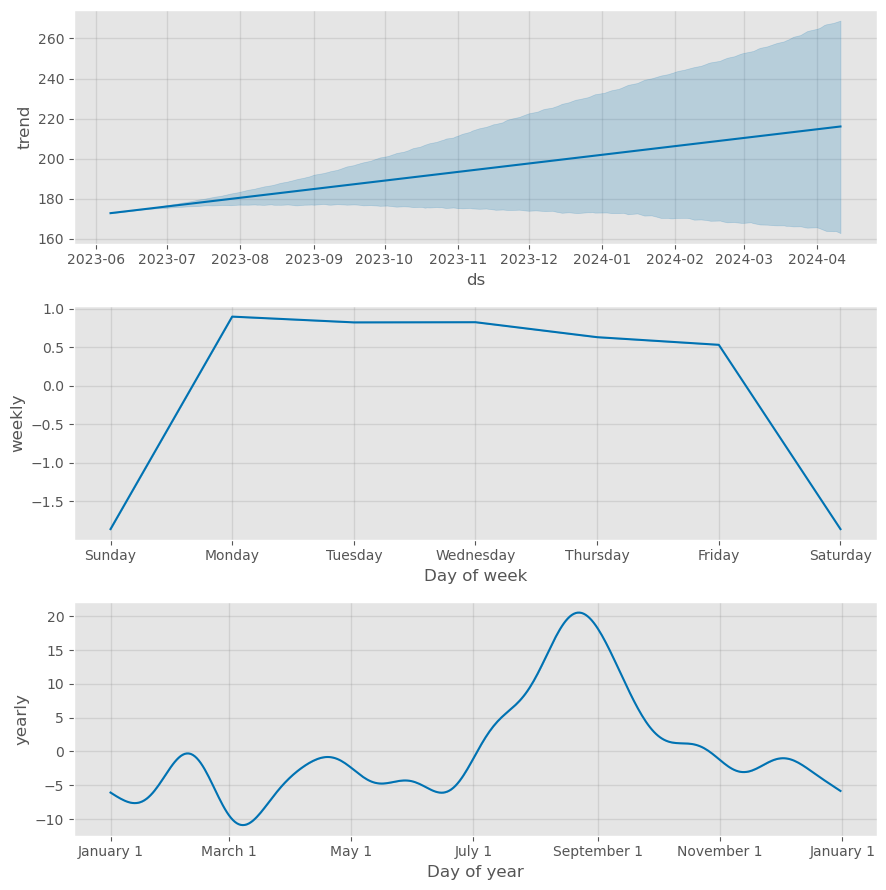

In [127]:
prophet.plot_components(test_predict)

Predicting in the Future

In [128]:
prophet_data = df_prophet.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})
prophet = Prophet()
prophet.fit(prophet_data)

17:50:33 - cmdstanpy - INFO - Chain [1] start processing
17:50:33 - cmdstanpy - INFO - Chain [1] done processing


In [129]:
future = prophet.make_future_dataframe(periods=num_days_pred, freq='d', include_history=False)
forecast = prophet.predict(future)
forecast_prophet = forecast[['ds','yhat']]
forecast_prophet.index = forecast_prophet.pop('ds')

In [130]:
forecast_prophet

,yhat
ds,
2024-04-12,174.785166
2024-04-13,181.612789
2024-04-14,181.598983
2024-04-15,174.918439
2024-04-16,174.831848
2024-04-17,174.807422
2024-04-18,174.565856
2024-04-19,174.433395
2024-04-20,181.132924


# ARIMA

In [131]:
df_arima = stock_data.copy()

Split

In [132]:
split_date = df_prophet.index[int(len(df_arima) * 0.8)]
train_arima = df_arima.loc[df_arima.index <= split_date].copy()
test_arima = df_arima.loc[df_arima.index > split_date].copy()

hyperparamter tuning 

In [133]:
# Try to find the best parameters for arima model 
stepwise_fit = auto_arima(train_arima['Close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4147.383, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4143.955, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4143.234, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4143.035, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4143.555, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4143.812, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4144.039, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4145.736, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4142.852, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4143.838, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4143.992, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4143.024, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4145.761, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.843 seconds


train

In [134]:
arima = ARIMA(train_arima['Close'], order=best_order)
arima = arima.fit()

evaluate

In [135]:
start = len(train_arima)
end = len(test_arima) + len(train_arima)

In [136]:
pred_arima = arima.predict(start=start,end=end-1)

In [137]:
pred_arima.index = test_arima.index

<Axes: xlabel='Date'>

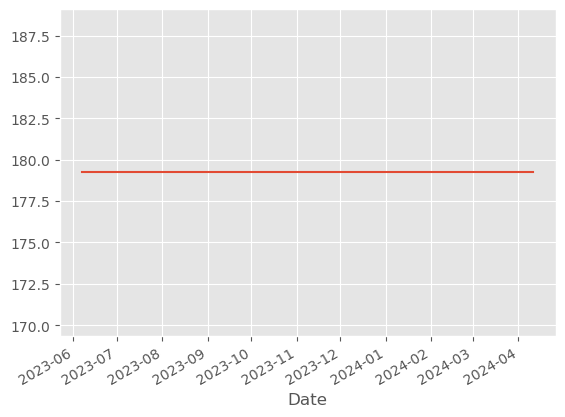

In [138]:
pred_arima.plot()

In [139]:
arima_loss = mean_absolute_percentage_error(test_arima['Close'],pred_arima )
print(f"ERROR PERCENT = { mean_absolute_percentage_error(test_arima['Close'],pred_arima ) }% ")

ERROR PERCENT = 4.127049673022025% 


predict into future

In [140]:
# Try to find the best parameters for arima model 
stepwise_fit = auto_arima(df_arima['Close'],trace=True,suppress_warnings=True)
# assign the parameter to "best_order" variable
best_order = stepwise_fit.get_params()['order']

arima = ARIMA(df_arima['Close'], order=best_order)
arima = arima.fit()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5096.137, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5105.221, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5105.993, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5105.948, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5104.480, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5109.420, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5109.420, Time=0.63 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5109.642, Time=1.42 sec


In [ ]:
start = len(df_arima)
end = len(df_arima) + num_days_pred
arima_forecast = arima.predict(start=start,end=end)

In [ ]:
start = df_arima.index.max()
end = start + pd.Timedelta(days=num_days_pred)
arima_forecast.index = pd.date_range(start, end, freq='1d')

In [ ]:
arima_forecast = pd.DataFrame(arima_forecast)

# Communicate the results

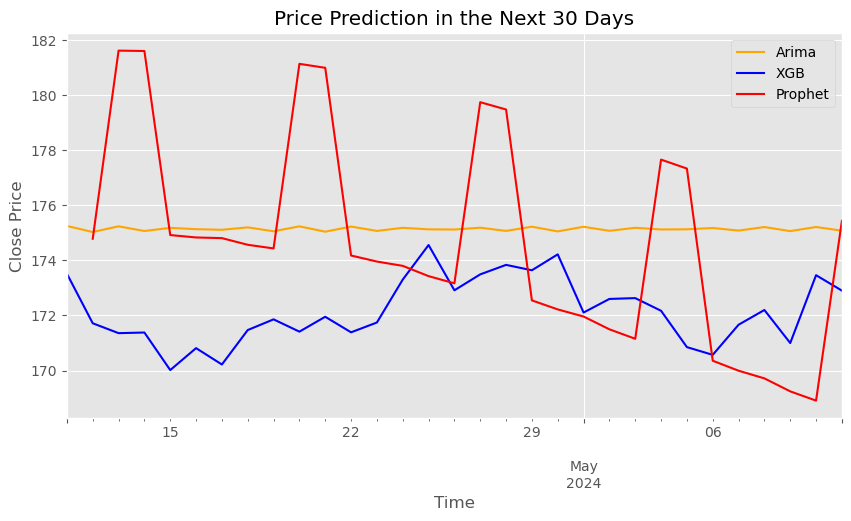

In [ ]:
fig, ax  = plt.subplots(figsize=(10,5))
arima_forecast.plot(color='orange',ax=ax)
prediction_xgb.plot(color = 'blue',ax=ax)
forecast_prophet.plot(color = 'red',ax=ax)
plt.legend(['Arima','XGB','Prophet'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(f"Price Prediction in the Next {num_days_pred} Days");

In [ ]:
print(f"XGB Acc : {100-xgb_loss} \nArima Acc : {100-arima_loss}\nProphet Acc : {100- porphet_loss}")

XGB Acc : 98.32269238680995 
Arima Acc : 95.87295032697797
Prophet Acc : 90.54675757619188
